In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import sys #access to system parameters
print("Python version: {}". format(sys.version))

import numpy as np # linear algebra
print("NumPy version: {}". format(np.__version__))
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print("pandas version: {}". format(pd.__version__))

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
import sklearn
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('scikit-learn version: {}.'.format(sklearn.__version__))

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

#plt.style.use('fivethirtyeight')

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Python version: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
NumPy version: 1.16.3
pandas version: 0.23.4
scikit-learn version: 0.20.3.
['wine-reviews', 'titanic']


In [3]:
# SUMMARISE THE DATA
# ===============================================================

# -----------------------------------------------------
# Get the names of all features in the dataset
# -----------------------------------------------------
def get_feature_names(df):
    return df.columns.values

# -----------------------------------------------------
# Print a summary of all the features in the dataset
# -----------------------------------------------------
def data_summary (df, features_dict):
    # Get Feature names
    print('Features are ', get_feature_names(df))
    
    print('_'*40, 'Categories of all features', '_'*20)
    print (features_dict)
    
    print('_'*40, 'Datatypes of all features', '_'*20)
    # Print datatypes of all the features
    df.info()

    # Stats of the features
    # Check the quantiles and min/max to see if any of the features have anomalies or outliers
    df.describe(include = 'all')
    
# -----------------------------------------------------
# Quick preview of a few rows in the dataset
# -----------------------------------------------------
def data_preview (df):
    #df.head()
    #df.tail()
    df.sample(10)

In [4]:
# SUMMARISE THE DATA
# ===============================================================

# -----------------------------------------------------
# Get a list of all the unique values for a feature (usually categorical)
# -----------------------------------------------------
def get_unique_values (df, target):
    return df[target].unique()

# -----------------------------------------------------
# Get a count of unique values for 'Object' columns
# -----------------------------------------------------
def get_unique_counts (df):
    return (df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))

# -----------------------------------------------------
# Print the most frequently occuring values of each categorical column
# -----------------------------------------------------
def count_freq (df, cat_cols):
    for col in cat_cols:
        print (df[col].value_counts().nlargest())

# -----------------------------------------------------
# Return a dataframe with all the datatypes in the given df
# -----------------------------------------------------
def get_dtypes (df):
    dtype_df = df.dtypes.reset_index()
    dtype_df.columns = ["Feature", "Column Type"]
    dtype_df['Column Type'] = dtype_df['Column Type'].astype(str)
    return (dtype_df)
        
# -----------------------------------------------------
# Get all the number-type columns in the dataframe
# -----------------------------------------------------
def get_numeric_columns (df):
    return (df.select_dtypes('number').columns)

# -----------------------------------------------------
# Return a dataframe with the number and percentage of missing 
# values for each feature
# -----------------------------------------------------
def missing_values_summary(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Combine them into a single results table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing value information
        return mis_val_table_ren_columns

In [5]:
# VISUALISATION PLOTTING
# ===============================================================

# -----------------------------------------------------
# Generic Plotter class which encapsulates all plotting functionality
# All methods are meant to be statics, so you can create a single
# dummy instance and call them
# -----------------------------------------------------
class Plotter(object):
    def __init__(self, grid_row = 4, grid_col = 4, figsize = 18):
        self.grid_row = grid_row
        self.grid_col = grid_col
        self.figsize = figsize
        self.fig = self._create_fig ()

    # Create a grid of subplots using the given plot type. Each 
    # subplot graphs one feature in the dataframe using the same
    # plot type
    def plot_grid (self, ptype, df, features, target=None):
        # Create a subplot for each feature
        for feature in features:
            self.create_subplot (ptype, df, feature, target)

    # Create a new subplot at the next position in the grid
    def create_subplot (self, ptype, df, x, y=None):       
        fig = self.fig
        # New subplot will be created at a position that is 1 more 
        # than the existing count of subplots
        pos = len(fig.axes) + 1
        ax = fig.add_subplot(self.grid_row, self.grid_col, pos)
        # Get the plotting function based on the plot type...
        plot_func = self._get_plottype (ptype)
        # ... and call the function
        plot_func (df, x, y)
        return (ax)

    # Create the top-level figure
    def _create_fig (self):
        fig = plt.figure(figsize = (self.figsize, self.figsize))
        # Spacing between the subplots
        plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
        return (fig)
    
    # Get the method for the required plot type
    def _get_plottype (self, ptype):
        # Generate the method name for the plot type
        method_name = '_plot_' + ptype
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, method_name, lambda: "Invalid plot type")
        # Return the method
        return method
 
    # There is a separate method for each type of plot. Each method
    # name follows a naming convention ie. "_plot_<plot type>"
    # Bar graph of the total number of values for each 'x'
    def _plot_count(self, df, x, y):
        sns.countplot(x=x, data=df)
 
    # Histogram
    def _plot_dist(self, df, x, y):
        #sns.distplot(df[x], kde=False)
        sns.distplot(df[x])
 
    # Bar graph plots the mean of all the 'y' values for each 'x'
    def _plot_bar(self, df, x, y):
        sns.barplot(x=x, y=y, data=df)

    def _plot_multicol(self, df, x, y):
        sns.barplot(df.index, df[x])
        
    def _plot_series(self, df, x, y):
        sns.barplot(df.index, df.values)
        
    def _plot_series_horiz(self, df, x, y):
        sns.barplot(df.values, df.index)
        
    def _plot_box(self, df, x, y):
        sns.boxplot(df[x], df[y])
        
    def _plot_reg(self, df, x, y):
        sns.regplot(x=x, y=y, data=df)

    def _plot_scatter(self, df, x, y):
        sns.scatterplot(x=x, y=y, data=df)
        
def plot_corr(df):
    # Heatmap of correlations
    plt.figure(figsize = (8, 6))
    sns.heatmap(df.corr(), vmin = -0.25, annot = True, vmax = 0.6, cmap = plt.cm.RdYlBu_r, fmt='.2f', linewidths=.05)
    plt.title('Correlation Heatmap');

In [6]:
# BIVARIATE VISUALISATION
# ===============================================================

# -----------------------------------------------------
# Plots bar plots between a feature and a target pair
# -----------------------------------------------------
def plot_pair_target (df, features, target):
    grid_size = 4
    fig = plt.figure(figsize = (15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        sns.barplot(x = feature, y = target, data=df, ax = ax)
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Totals'.format(feature), fontsize=16)

# -----------------------------------------------------
# Plot Stacked histograms of each feature vs target
# -----------------------------------------------------
def plot_stackhist(df, features, target):
    grid_size = 4
    fig = plt.figure(figsize = (20, 20))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    # Get list of unique values of the target
    target_values = get_unique_values (df, target)
        
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        # For each value of the target
        dist = [df[df[target]==val][feature] for val in target_values]
        ax.hist(x = dist, stacked=True, label = target_values)
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Distribution'.format(feature), fontsize=16)
        ax.legend()

In [7]:
# MULTIVARIATE VISUALISATION
# ===============================================================

# -----------------------------------------------------
# Pair-Grid Plot between each pair of features
# -----------------------------------------------------
def plot_pair(df, features):
    # Pair-wise Scatter Plots
    pp = sns.pairplot(df[features], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

    fig = pp.fig 
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('Pairwise Plots', fontsize=14)


In [8]:
# SUMMARISE THE DATA
# ===============================================================

# -----------------------------------------------------
# Visualise basic stats of the data
# -----------------------------------------------------
def data_stats (df):
    p = Plotter()
    
    # Get all the datatypes
    dd = get_dtypes (df)
    p.create_subplot ('count', dd, 'Column Type')
    
    # Unique value counts
    ud = get_unique_counts(train_df)
    p.create_subplot ('series', ud, 'dummy')

    # Missing value counts
    miss_val = missing_values_summary(train_df)
    cols = get_feature_names(miss_val)
    p.plot_grid ('multicol', miss_val, cols)

In [9]:
# VISUALISE THE DATA
# ===============================================================

def data_distrib (df, cat_cols, num_cols):
    p = Plotter()
    #Frequency of categorical values
    p.plot_grid ('count', df, cat_cols)

    # Histograms of Numerical features
    p.plot_grid ('dist', df, num_cols)

In [10]:
# EXPLORATORY DATA ANALYSIS - BIVARIATE
# ===============================================================

# -----------------------------------------------------
# Return true if the given feature is Categorical
# -----------------------------------------------------
def is_categorical(df, col):
    return df[col].dtype.name == 'category'

# -----------------------------------------------------
# Bivariate plot of each feature with the target. 
# If the target is Categorical, use Bar Graphs
# If the target is Numerical, use Scatter plots for numeric features and..
#                         ...Box plots for categorical features
# -----------------------------------------------------
def data_target (df, cat_cols, num_cols, target):
    p = Plotter()
    if (is_categorical (df, target)):
        plot_pair_target (train_df, cat_cols, target)
        #plot_stackhist(train_df, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Sex'], 'Survived')
    else:
        p.plot_grid ('scatter', df, num_cols, target)
        p.plot_grid ('box', df, cat_cols, target)

In [11]:
# CLEAN THE DATA
# ===============================================================

# -----------------------------------------------------
# Remove columns which are not selected for the model
# -----------------------------------------------------
def remove_cols (dfs, cols):
    for df in dfs:
        #print("DF shape before", df.shape)
        df.drop(cols, axis=1, inplace = True)
        #print("DF shape after", df.shape)

In [12]:
# COMPLETE THE DATA
# ===============================================================

# -----------------------------------------------------
# Fill in all missing values by imputing those values
# -----------------------------------------------------
def impute_missing_values (df, cols):
    # Get the numeric columns and impute average values for them
    num_df = df[cols].select_dtypes(exclude=[object])
    
    # NB: Imputer has now been deprecated, use SimpleImputer instead
    imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imr = imr.fit(num_df)
    df[num_df.columns] = imr.transform(num_df.values)
    
    # Get the categorical columns and impute the mode values for them
    cat_df = df[cols].select_dtypes('object')
    cat_df.fillna(cat_df.mode().iloc[0], inplace = True)
    df[cat_df.columns] = cat_df

# -----------------------------------------------------
# Fill all missing numeric values with 0
# -----------------------------------------------------
def fill_missing (df):
    # Iterate through the numeric columns 
    for col in df.select_dtypes('number').columns:
        df[col] = df[col].fillna(0)

In [13]:
# CONVERT THE DATA
# ===============================================================

# -----------------------------------------------------
# Convert a numeric column to a categorical column based on ranges defined by bins
# -----------------------------------------------------
def num_to_cat (df, num_col, cat_col, bins, labels):
    df[cat_col] = pd.cut(df[num_col], bins=bins, labels=labels)

# -----------------------------------------------------
# Label encode categorical columns
# -----------------------------------------------------
def encode_cat (df, cat_col, enc_col):
    gle = LabelEncoder()
    # Fill missing values with a dummy string, otherwise fit_transform throws an error
    #cat_labels = gle.fit_transform(df[cat_col].fillna('Empty'))
    cat_labels = gle.fit_transform(df[cat_col])
    #cat_mappings = {index: label for index, label in enumerate(gle.classes_)}
    df[enc_col] = cat_labels
    
# -----------------------------------------------------
# One-hot encode categorical columns
# -----------------------------------------------------
def encode_cat_onehot (df, cat_col):
    # Drop the first encoded value to avoid the "dummy variable trap"
    # NB: You can also use sklearn's OneHotEncoder() but that returns a numpy array
    # which will have to be converted into a dataframe
    onehot_df = pd.get_dummies(df[cat_col], drop_first=True)
    #onehot_df = pd.get_dummies(df[cat_col].fillna('Empty'), drop_first=True)
    return (pd.concat([df, onehot_df], axis=1))

# -----------------------------------------------------
# Min-Max Scaling
# -----------------------------------------------------
def minmax_scaling (df, cols):
    # Get np array for scaling. 
    # Adjust to 2D if cols contains only a single element
    x = df[cols].values
    if (x.ndim == 1):
        x = x.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1)) 
    x_after_min_max_scaler = min_max_scaler.fit_transform(x)
    df[cols] = x_after_min_max_scaler

In [14]:
# EXPLORATORY DATA ANALYSIS - BIVARIATE
# ===============================================================

# -----------------------------------------------------
# Plot correlations of features with the target feature
# -----------------------------------------------------
def correlations_target(df, target):
    return (df.corr()[target].sort_values())

# -----------------------------------------------------
# Plot correlations with target and also heatmap of correlation between
# all features
# -----------------------------------------------------
def data_correlations (df, num_cols, target):
    tc = correlations_target(df, target)
    p = Plotter()
    p.plot_grid ('series_horiz', tc, ['dummy'], 'dummy')
    
    # Heatmap of correlations between all features
    plot_corr (df)

In [15]:
# CREATE NEW FEATURES (AGGREGATE CHILD TABLES)
# ===============================================================

def agg_numeric(df, group_var, stats, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Group by the specified variable and calculate the statistics
    agg = df.groupby(group_var).agg(stats).reset_index()
    
    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [16]:
def copy_df (df):
    #Create a copy of data before manipulation.Python assignment or equal passes by 
    # reference vs values, so we use the copy function
     return (df.copy(deep = True))

# Get intersection between two dataframes based on values in a column
def intersect_col (df1, df2, col):
    return pd.Series (list (set(df1[col]) & set (df2[col])))

# Get difference between two dataframes based on values in a column
def diff_col (df1, df2, col):
    return df1[~df1[col].isin(df2[col])]

In [17]:
# CREATE NEW FEATURES (POLYNOMIAL)
# ===============================================================

# -----------------------------------------------------
# Create polynomial features
# -----------------------------------------------------
def polynomial_features (df, test_df):
    poly = PolynomialFeatures(degree=2).fit(df)
    poly_df = poly.transform(df)
    test_poly_df = None
    if (test_df):
        test_poly_df = poly.transform(test_df)
    return (poly_df, test_poly_df)

In [18]:
# RUN MODEL 
# ===============================================================

# -----------------------------------------------------
# Plot Learning Curve for different sizes of the training samples
# -----------------------------------------------------
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):    
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    if ylim is not None:
        plt.ylim(*ylim)
    
    # Create Cross Validation training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Create means and standard deviations of training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Draw curve lines
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Titles, labels, grid, legend etc
    plt.title(title)
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.grid()

    return plt

In [19]:
# RUN MODEL 
# ===============================================================

# -----------------------------------------------------
# Plot Validation Curve for different hyperparameter values
# -----------------------------------------------------
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    # Create validation scores
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
     # Draw curve lines
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    
    # Draw bands
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    
    # Titles, labels, grid, legend etc
    plt.title(title)
    plt.xlabel('Parameter values'), plt.ylabel('Accuracy Score'), plt.legend(loc='best') 
    plt.grid() 
    plt.xscale('log')
    plt.ylim(ylim)

In [20]:
# RUN MODEL 
# ===============================================================

# -----------------------------------------------------
# -----------------------------------------------------
def run_model (X, y, model):
    # Fit the model to the training data
    model.fit(X, y)

    # Model performance
    scores = cross_val_score(model, X, y, cv=10)
    return (scores)

In [21]:
# RUN MODEL 
# ===============================================================

# -----------------------------------------------------
# Run a cross-validation model with the given data, and plot the learning 
# and validation curves
# -----------------------------------------------------
def validate_model (X, y, model=None):
    # Split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

    # Use Logistic Regression as the default
    if (model is None):
        model = LogisticRegression()
    scores = run_model (X_train, y_train, model)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # Figure and axes to plot learning and validation curves
    fig, axs = plt.subplots(1,2, figsize = (12, 5))
    
    # Plot learning curves
    title = "Learning Curves (Logistic Regression)"
    cv = 10
    plt.sca(axs[0]) # Set the current axes to first subplot
    plot_learning_curve(model, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

    # Plot validation curve
    title = 'Validation Curve (Logistic Regression)'
    param_name = 'C'
    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
    cv = 10
    plt.sca(axs[1]) # Set the current axes to next subplot
    plot_validation_curve(estimator=model, title=title, X=X_train, y=y_train, param_name=param_name,
                          ylim=(0.5, 1.01), param_range=param_range);

In [22]:
# MODEL SELECTION 
# ===============================================================

# -----------------------------------------------------
# Initialise classifiers and hyperparameter grids for all the ML algos
# For each ML algo, it creates a classifier. It also provides all the
# possible combinations of hyperparameter values for each algo.
# -----------------------------------------------------
def algo_param ():

    # Logistic Regression
    clf_logreg = LogisticRegression(multi_class='multinomial',
                              solver='newton-cg',
                              random_state=1)
    pgrid_logreg = [{'penalty': ['l2'],
                    'C': np.power(10., np.arange(-4, 4))}]
    name_logreg = "Logistic Regression"

    # K Nearest Neighbours
    clf_knn = KNeighborsClassifier(algorithm='ball_tree',
                                leaf_size=50)
    pgrid_knn = [{'n_neighbors': list(range(1, 10)),
                    'p': [1, 2]}]
    name_knn = "K Nearest Neighbours"

    # Decision Tree
    clf_dtree = DecisionTreeClassifier(random_state=1)
    pgrid_dtree = [{'max_depth': list(range(1, 10)) + [None],
                    'criterion': ['gini', 'entropy']}]
    name_dtree = "Decision Tree"
    
    # Support Vector Machine
    clf_svm = SVC(random_state=1)
    # KD - for some reason a linear kernel hangs the system, so don't use it for now
    pgrid_svmDONTUSE = [{'kernel': ['rbf'],
                    'C': np.power(10., np.arange(-4, 4)),
                    'gamma': np.power(10., np.arange(-5, 0))},
                    {'kernel': ['linear'],
                    'C': np.power(10., np.arange(-4, 4))}]
    TEMP_pgrid_svm = {'kernel': ['rbf'], "C": np.power(10., np.arange(-4, 4)),
          "gamma": np.power(10., np.arange(-5, 0))}
    pgrid_svm = {'kernel': ['rbf'], "C": np.power(10., np.arange(-1, 1)),
          "gamma": np.power(10., np.arange(-2, 0))}
    name_svm = "Support Vector Machine"
    
    # Random Forest
    clf_rf = RandomForestClassifier(n_estimators=20)
    TEMP_pgrid_rf = {"max_depth": [3, None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
    pgrid_rf = {"max_depth": [3], "max_features": [1], "min_samples_split": [2], "bootstrap": [True], "criterion": ["gini", "entropy"]}
    name_rf = "Random Forest"

    # Naive Bayes
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!
    # KD - For now we will exclude Naive Bayes because it has no hyper parameters to tune and
    # results in an error during nested CV. Have to figure out how to resolve
    clf_nb = GaussianNB()
    pgrid_nb = []
    name_nb = "Naive Bayes"
    
    # Return a list of tuples of all algos (one tuple per algo)
    algos = [(clf_logreg, pgrid_logreg, name_logreg),
             (clf_knn, pgrid_knn, name_knn),
             (clf_dtree, pgrid_dtree, name_dtree),
             (clf_svm, pgrid_svm, name_svm),
   #         (clf_nb, pgrid_nb, name_nb),
             (clf_rf, pgrid_rf, name_rf)
            ]
    return (algos)

In [23]:
# MODEL SELECTION 
# ===============================================================

# -----------------------------------------------------
# Nested cross-validation to find the best combination of hyperparameter 
# values for a given algo. It runs a model for every possible combination
# of values using nested cross-validation, picks the best one and 
# returns the scores for that model.
# Nested CV has an outer loop, for which it uses cross_val_score() and
# an inner loop for which it uses GridSearchCV(). The inner loop selects
# the model with the best hyperparameter combination, and the outer loop
# evaluates that model by estimating its performance score.
# Note that Nested Cross-Validation does not output the model itself, nor
# does it output the hyperparameter values themselves. It only tells you
# what a reliable score would be if such a model was used on new test
# data which has not been provided to the model before. It also outputs
# a GridSearch classifier which can then be fitted with the full training
# data to get the actual model and hyperparameter values. This bit is not
# done below, but in the caller.
# -----------------------------------------------------
def nested_cv (def_algo, X, y):
    # Classifier object, grid of hyperparameter value combinations and the textual name of the algo
    clf_algo, pgrid_algo, name_algo = def_algo
    
    # Scoring methods to evaluate the model performance
    scoring = ['roc_auc', 'accuracy', 'precision', 'recall']
    #scoring = 'accuracy'
    
    # Arrays to store scores
    trial_scores = []

    # Run the nested CV multiple times.
    # Note that these multiple trials is not a requirement of the Nested CV. We are
    # choosing to do it so we can get multiple readings.
    NUM_TRIALS = 3
    
    # Repeat for each trial
    for i in range(NUM_TRIALS):

        # Choose cross-validation techniques for the inner and outer loops,
        # independently of the dataset.
        # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
        inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

        # Create the classifier for the inner loop, which does the hyperparameter
        # search by scoring the algo with each combination of hyperparameter values
        # Note that this step only creates the classifier, it does not execute the
        # inner loop here.
        inner_gs = GridSearchCV(estimator=clf_algo, param_grid=pgrid_algo, cv=inner_cv, 
                           scoring=scoring, n_jobs=1,verbose=0, refit='accuracy')

        # Create the outer loop and pass the inner loop classifier to it. Both the
        # outer loop and inner loop are executed internally within this one line.
        # The outer loop independently evaluates the performance of the hyperparameter
        # combination that was selected by the inner loop. Independent evaluation means
        # that it is tested on a different set of data than that used by the inner
        # loop.
        nested_score = cross_val_score(inner_gs, X=X, y=y, cv=outer_cv)
        
        # nested_score is an array with one score for each iteration of the outer loop
        # Compute the mean and standard deviation of those scores
        # That becomes the mean score and std score for the ith trial
        trial_score = {'Name': name_algo, 
                       'Accuracy': nested_score.mean() * 100, 
                       'Std': nested_score.std() * 100, 
                       'Trial' : i
                      }
        trial_scores.append (trial_score)

    # The caller can then use this inner_gs to fit the full training data and get
    # the actual model and hyperparameter values. We also return the scores for all
    # the trials
    scores_df = pd.DataFrame (trial_scores)
    avg_accuracy = scores_df ['Accuracy'].mean()
    avg_std = scores_df ['Std'].mean()
    return (scores_df, avg_accuracy, avg_std, inner_gs)

In [24]:
# MODEL SELECTION 
# ===============================================================

# -----------------------------------------------------
# Find the best model (ie. ML algo and hyperparameters) for the given data
# It uses Nested Cross-Validation to exhaustively try every algo, along
# with all combinations of hyperparameter values. It then uses those
# scores to select the best one
# -----------------------------------------------------
def best_algo (X, y):
    all_algos_df = pd.DataFrame()
    all_gs = []
    best_accuracy = 0.
    best_gs = None
    
    # Get details of each ML algo including hyperparameter combinations
    all_algos = algo_param()
    
    # Evaluate each algo and find the best one
    for algo in all_algos:
        _, _, algo_name = algo
        
        # Run Nested CV for this algo
        algo_scores_df, algo_accuracy, algo_std, algo_gs = nested_cv (algo, X, y)
        print ('Algo ', algo_name, ' has accuracy ', algo_accuracy, 'with std', algo_std)
        
        # Append results from this algo
        all_gs.append (algo_gs)
        all_algos_df = all_algos_df.append (algo_scores_df)
        
        # Check if this algo's accuracy is the best so far
        if (algo_accuracy > best_accuracy):
            best_accuracy = algo_accuracy
            best_gs = algo_gs
            
    print ('Best accuracy is ', best_accuracy)
    
    # Return results from all our algos
    return (all_algos_df, all_gs, best_gs)

In [25]:
# MODEL SELECTION 
# ===============================================================

# -----------------------------------------------------
# Use the given GridSearch to fit a model with the best hyperparameter values
# Here is where we create the actual model based on the GridSearch
# from the Nested CV
# -----------------------------------------------------
def fit_model (gs, X, y):
    # The given GridSearch has already been seeded with all the hyperparameter 
    # combinations during Nested CV. Fit it again here to get the best
    # combination
    gs.fit(X, y)

    # We can continue to use the fitted gs classifier for running the model. 
    # However we can also get the classifier for the best algo found by the
    # gs classifier, and use that directly instead.
    clf = gs.best_estimator_
    clf.fit(X, y)
    return (clf, gs.cv_results_, gs.best_params_, gs.best_score_)

In [26]:
# MODEL SELECTION 
# ===============================================================

# -----------------------------------------------------
# Produce a DataFrame for reporting on the scores of each hyperparameter
# combination for an algo
# -----------------------------------------------------
def report_algo_params (results):
    # Get the list of all hyperparameter combinations (and cast to strings for plotting)
    params = [ str(param) for param in results['params']]
    
    # Means and Standard Deviations for each hyperparameter combination
    # Note that the keys would be called 'mean_test_score' and 'std_test_score'
    # if we used a single accuracy scoring metric in nested_cv. Since we are using
    # multiple scoring metrics instead, there are separate keys for each metric
    # named mean_test_<metric> eg. mean_test_precision, mean_test_recall etc.
    means = results['mean_test_accuracy']
    stds = results['std_test_accuracy']
    
    # Create a dataframe from it for analysis
    pdf = pd.DataFrame ({'Params': params, 'Mean' : means, 'Stds' : stds})
    return (pdf)

# -----------------------------------------------------
# Format metric values for reporting
# -----------------------------------------------------
def format_metric (metric):
    formatted_metric = float("{0:.2f}".format(100 * metric))
    return (formatted_metric)

# -----------------------------------------------------
# Produce a DataFrame for reporting on the metrics of a fitted model
# -----------------------------------------------------
def report_model_metrics (gs, X_train, y_train, X_test, y_test):
    # Predictions on training and test set
    y_pred_train = gs.predict(X_train)
    y_pred_test = gs.predict(X_test)
    
    # Compute metrics based on the predictions
    acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    precision_test = precision_score(y_true=y_test, y_pred=y_pred_test)
    recall_test = recall_score(y_true=y_test, y_pred=y_pred_test)
    
    # Create a confusion matrix from the predictions
    confmat = confusion_matrix(y_test,y_pred_test)

    metrics = [{'Type':'CV Accuracy', 'Value': format_metric (gs.best_score_)},
                {'Type':'Training Accuracy', 'Value' : format_metric (acc_train)},
                {'Type':'Test Accuracy', 'Value' : format_metric (acc_test)},
                {'Type':'Precision', 'Value' : format_metric (precision_test)},
                {'Type':'Recall', 'Value' : format_metric (recall_test)}
             ]
    metrics_df = pd.DataFrame (metrics)
    
    return (metrics_df, confmat)

# -----------------------------------------------------
# Print out a classification report
# -----------------------------------------------------
def clf_classification_report (clf, X_test, y_test):
    print ('---------------clf_classification_report------------------')
    print('Test accuracy: %.3f' % clf.score(X_test, y_test))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print('+++ Calc Precision and Recall by had ===')
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

# -----------------------------------------------------
# Plot curves for all the score metrics during GridSearch against 
# one of the hyperparameter values
# !!!!!!!!!!!!!!!KD NOTE - there is one major flaw that needs to be 
# resolved the param_name and X_param have to be figured out dynamically
# and will be different for different ML algos. Right now it is
# largely hard-coded to work with a specific param only
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# -----------------------------------------------------
def plot_multi_score (multi_score_info):
    results, X_param, param_name, score_metrics = multi_score_info
    
    plt.figure(figsize=(6, 6))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel(param_name)
    plt.ylabel("Score")

    ax = plt.gca()
    #ax.set_xlim(-10, 1000)
    #ax.set_ylim(0.73, 1)

    for scorer, color in zip(sorted(score_metrics), ['g', 'k', 'b', 'r']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_param, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_param, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_param[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_param[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid('off')

In [27]:
# MODEL SELECTION 
# ===============================================================

# -----------------------------------------------------
# Report on the performance of the best model.
# It is the main reporting function that is called from best_model()
# and calls a number of reporting functions internally
# -----------------------------------------------------
def report_model_perf (best_gs, results, X_train, y_train, X_test, y_test):
    # Report on the scores for each hyperparameter combination
    param_df = report_algo_params (results)
    
    # Report on the final model that we fitted
    metrics_df, confmat = report_model_metrics (best_gs, X_train, y_train, X_test, y_test)
    
    # Classification report - this should be removed
    #clf_classification_report (best_model, X_test, y_test)

    # Get the regular numpy array from the MaskedArray
    param_name = 'max_depth'
    X_param = np.log (np.array(results['param_' + param_name].data, dtype=float))
    
    # Info needed to plot multi_score graph
    score_metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
    multi_score_info = (results, X_param, param_name, score_metrics)
    
    return (param_df, metrics_df, confmat, multi_score_info)

# -----------------------------------------------------
# Get the best model for the data and report on performance metrics
# This is the main top-level function for model selection which
# then calls all of the child functions internally
# -----------------------------------------------------
def best_model (X, y):
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
    
    # Find the best algo and hyperparameter combination
    algo_df, _, best_gs = best_algo (X_train, y_train)
    algo_df = algo_df.set_index(['Name', 'Trial'], drop = False)
    
    # Fit a model to the best algo found
    best_model, results, best_params, best_score  = fit_model (best_gs, X_train, y_train)
    print('Best params ', best_params)
    #print('Best accuracy', best_score)
    
    # Get details for reporting performance results for the model
    param_df, metrics_df, confmat, multi_score_info = report_model_perf(best_gs, results, X_train, y_train, X_test, y_test)

    # Return all the results so that we can display them
    return (algo_df, param_df, metrics_df, confmat, multi_score_info)

In [28]:
# FEATURE SELECTION 
# ===============================================================

# -----------------------------------------------------
# Select the best k features for a given value of k. 
# Internally, it tries every possible combination of k features from
# the total set of features and scores each combination using 
# chi-squared test. Finally it returns a Dataframe of the 
# chosen k features
# -----------------------------------------------------
def selected_df (X, y, k):
    select = SelectKBest(score_func=chi2, k=k)
    select.fit(X, y)
    X_selected = select.transform(X)
    return (X_selected)

# -----------------------------------------------------
# Find the optimal number of features which will give us the best score.
# It tries every possible value of k, and for each such value it
# gets the best set of k features. It gets the scores for each such
# model and returns the highest score.
# -----------------------------------------------------
def feature_select (X, y, base_score = 0):
    # Start with the current baseline score as our floor
    highest_score = base_score
    
    # Try every value of k upto the total number of features in the dataset
    for k in range(1, X.shape[1]+1, 1):
        # Get the best combination of features for this value of k
        X_selected = selected_df (X, y, k)

        # Run a model with those selected k features
        model = LogisticRegression()
        scores = run_model (X_selected, y, model)
        print('CV accuracy (number of features = %i): %.3f +/- %.3f' % (k, 
                                                                         np.mean(scores), 
                                                                         np.std(scores)))

        # Save results if this score was better than our current best score
        if np.mean(scores) > highest_score:
            highest_score = np.mean(scores)
            std = np.std(scores)
            k_features_highest_score = k
        elif np.mean(scores) == highest_score:
            if np.std(scores) < std:
                highest_score = np.mean(scores)
                std = np.std(scores)
                k_features_highest_score = k

    # Print the number of features
    print('Number of features when highest score: %i' % k_features_highest_score)
    return (k_features_highest_score)

In [29]:
# UNUSED - These functions have been superseded by better implementations or are
# no longer needed. None of them are now being used.
# ===============================================================

# Plot a bar chart of a Series
def plot_series (df):
    fig = plt.figure(figsize = (5, 5))
    ax = plt.axes()
    
    data_x, data_y = df.index, df.values
    ax.bar(data_x, data_y, color='lightseagreen')
    ax.set_xlabel("Features")
    ax.set_ylabel("Counts") 
    ax.set_title('Unique', fontsize=16)

# Plots all the columns in a dataframe against the index
def plot_multicolumn (df, features):
    grid_size = 4
    fig = plt.figure(figsize = (15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        data_x, data_y = df.index, df[feature].values
        #ax.bar(data_x, data_y, color='teal')
        sns.barplot (data_x, data_y)
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Totals'.format(feature), fontsize=16)

def plot_bar (df, features):
    grid_size = 4
    plt.subplots_adjust(top=.85, hspace=0.7, wspace=0.4)
    
    for i, feature in enumerate(features):
        plt.subplot(grid_size, grid_size, i + 1)
        #df.groupby(feature)['Survived'].agg('sum').nlargest().plot (kind = 'bar')
        #df[feature].value_counts().plot (kind = 'bar')
        ax = df[feature].value_counts().nlargest().plot.bar(
            figsize=(15, 15),
            color='mediumvioletred',
            fontsize=12
        )
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Totals'.format(feature), fontsize=16)

# Plot a single column
def plot_column (df, col):
    fig = plt.figure(figsize = (5, 5))
    ax = plt.axes()
    
    data_x, data_y = df.index, df[col].values
    ax.bar(data_x, data_y, color='mediumvioletred')
    ax.set_xlabel("Features")
    ax.set_ylabel("Counts") 
    ax.set_title(col, fontsize=16)

# Plots only the subplots in the grid for which we have data
def plot_subplots (df, features):
    grid_size = 4
    fig = plt.figure(figsize = (15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.text(0.5, 0.5, str(i),
                      fontsize=12, ha='center')
        data = df[feature].value_counts().nlargest()
        data_x, data_y = data.index, data.values
        ax.bar(data_x, data_y, color='green')
        #sns.barplot(data_x, data_y)
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Totals'.format(feature), fontsize=16)

def plot_hist(df, features):
    grid_size = 4
    fig = plt.figure(figsize = (15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.hist(df[feature], color='orange')
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Distribution'.format(feature), fontsize=16)
        
# PIVOT (PAIR)
# Pivot the nominal, ordinal and discrete features against the Target
def plot_pivot_pair (df, features, target):
    grid_size = 4
    fig = plt.figure(figsize = (15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        pdf = pivot_pair (df, feature, target)
        ax.bar(pdf[feature], pdf[target], color='olive')
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Totals'.format(feature), fontsize=16)

# Plots a complete grid
def plot_grid (df, features):
    grid_size = 4
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        row, col = i // grid_size, i % grid_size
        ax = axs[row, col]
        ax.text(0.5, 0.5, str(i),
                      fontsize=12, ha='center')
        data = df[feature].value_counts().nlargest()
        data_x, data_y = data.index, data.values
        ax.bar(data_x, data_y, color='mediumvioletred')
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Totals'.format(feature), fontsize=16)        
       
def plot_box(df, features):
    grid_size = 4
    fig = plt.figure(figsize = (15, 15))
    plt.subplots_adjust(top=.85, hspace=0.3, wspace=0.3)
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.boxplot(df[feature], showmeans = True, meanline = True)
        ax.set_xlabel("Values")
        ax.set_ylabel("Counts") 
        ax.set_title('{} Distribution'.format(feature), fontsize=16)
        
plot_pivot_pair (train_df, ['Sex', 'Embarked', 'SibSp', 'Parch', 'Pclass'], 'Survived')

#plot_subplots (train_df, ['Survived', 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'])
#plot_bar(train_df, ['Survived', 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'])
#plot_hist(train_df, ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare'])

# Distribution of all features
#train_df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,xlabelsize=8, ylabelsize=8, grid=False)    
#plt.tight_layout(rect=(0, 0, 1.2, 1.2))

# Function to calculate pair-wise correlations between all columns and a target column
# Function replaced by correlations_target()
def target_corrs(df, target):

    # List of correlations
    corrs = []

    # Iterate through the numeric columns 
    for col in df.select_dtypes('number').columns:
        # Skip the target column
        if col != target:
            # Calculate correlation with the target
            corr = df[target].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

# Pair-wise correlations with the Target feature
tc = target_corrs (train_df, 'Survived')

# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df, target):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df[target].corr(df[var_name])
    
    plt.figure(figsize = (12, 6))
    
    # Get list of unique values of the target
    target_values = get_unique_values (df, target)
    
    # Plot the distribution for each value of the target
    for val in target_values:
        sns.kdeplot(df.ix[df[target] == val, var_name], label = 'TARGET == ' + str(val))
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the target %s is %0.4f' % (var_name, target, corr))
    
    # Print out median values
    for val in target_values:
        avg_val = df.ix[df[target] == val, var_name].median()
        print('Median value of %s for %s value %d = %0.4f' % (var_name, target, val, avg_val))

# Plot the Density plot of Age for different values of Survived
kde_target('Age', train_df, 'Survived')

# Pivot between a feature column and the target feature
def pivot_pair (df, col, target):
    return (df[[col, target]]).groupby([col], as_index=False).mean().sort_values(by=target, ascending=False)

# Pivot table to compute Target values for each combination between one or more rows and one or more columns
def pivot_multi (df, target, rows, cols):
    return (df.pivot_table(target, index=rows, columns=cols))

def plot_num_facet (df, target, row_col, num_col):
    g = sns.FacetGrid(df, col=target, row = row_col, height=2.2, aspect=1.6)
    g.map(plt.hist, num_col, alpha=.5, bins=20)
    g.add_legend()

plot_num_facet (train_df, 'Survived', None, 'Age')
plot_num_facet (train_df, 'Survived', 'Pclass', 'Age')
pivot_multi (train_df, 'Survived', ['Sex', 'Pclass'], 'Embarked')

NameError: name 'train_df' is not defined

## Wine Review Dataset

In [30]:
reviews = pd.read_csv("../input/wine-reviews/winemag-data_first150k.csv", index_col=0)

# Keep only the lower-priced wines...
md = reviews[reviews['price'] < 120]

# .. and split the numeric Points into bins and convert to a categorical Score...
bins = [0,84,89,100]
labels=[1, 2, 3]
num_to_cat (md, 'points', 'score', bins, labels)

# ... and Plot the Density plot of Price for different values of the Score
kde_target('price', md, 'score')

# Find missing values...
mt = missing_values_summary(reviews)

# ... and find any columns which have more than 90% missing values, and drop them from the data
mt_cols = list(mt.index[mt['% of Total Values'] > 90])
reviews = reviews.drop(columns = mt_cols)

# Compute aggregate statistics for numeric columns ...
agd = agg_numeric(md, group_var = 'country', stats = ['count', 'mean', 'max', 'min', 'sum'], df_name = 'ctry')

# ...and merge with the main data, and fill in empty values with 0s
agm = md.merge(agd, on = 'country', how = 'left')
fill_missing (agm)

agc = target_corrs (agm, 'points')
agc[:15]

# Encode the categorical Country name as a numeric Country ID
encode_cat (agm, 'country', 'country_id')
agm.head()

# One-hot encode the categorical Variety column
od = encode_cat_onehot (agm[['country', 'country_id', 'variety']], 'variety')
od.head()

# Note that we are aggregating stats for categorical columns which have now been one-hot encoded.
# Since these were not originally numeric values, the most meaningful stats are mean and sum
# Other stats like min and max do not make sense for such columns
# 
# The sum represents the count of that category value for that Country ID and 
# the mean represents the normalized count of that category value for that Country ID 
# ie. count of that value / total count of all values for that Country ID
# One-hot encoding makes the process of calculating these counts and normalised counts very easy
odm = agg_numeric(od, group_var = 'country_id', stats = ['mean', 'sum'], df_name = 'ctry')

# For some reason this step takes a long time and spikes the CPU to 100%. Need to check why.
odn = od.merge(odm, on = 'country_id', how = 'left')
odn.head()

NameError: name 'kde_target' is not defined

## Titanic Dataset

### Load the data and Preview it

In [31]:
# Load training data
#train_df = pd.read_csv('../input/titanic-machine-learning-from-disaster/train.csv')
train_df = pd.read_csv('../input/titanic/train.csv')

# Categorise features by type
target_feature = ['Survived'] # Nominal
nominal_features = ['Survived', 'Sex', 'Embarked']
ordinal_features = ['Pclass']
numeric_continuous_features = ['Age', 'Fare']
numeric_discrete_features = ['SibSp', 'Parch']
remove_features = ['PassengerId', 'Ticket', 'Cabin', 'Name'] # These may require data to be cleaned
features_dict = {'nominal': nominal_features,
                'ordinal' : ordinal_features,
                'continuous' : numeric_continuous_features,
                'discrete' : numeric_discrete_features,
                'remove' : remove_features,
                'target' : target_feature}

# preview the data
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S
588,589,0,3,"Gilinski, Mr. Eliezer",male,22.0,0,0,14973,8.0500,NaN,S
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
358,359,1,3,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
736,737,0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.3750,NaN,S
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
177,178,0,1,"Isham, Miss. Ann Elizabeth",female,50.0,0,0,PC 17595,28.7125,C49,C


### Summarise the data
* Shape, Columns, Datatypes
* Min-max Values
* Stats like Standard Dev, Quartiles
* Anomalies and Outliers

In [32]:
# Check the quantiles and min/max to see if any of the features have anomalies or outliers
train_df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [33]:
data_summary (train_df, features_dict)

Features are  ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
________________________________________ Categories of all features ____________________
{'nominal': ['Survived', 'Sex', 'Embarked'], 'ordinal': ['Pclass'], 'continuous': ['Age', 'Fare'], 'discrete': ['SibSp', 'Parch'], 'remove': ['PassengerId', 'Ticket', 'Cabin', 'Name'], 'target': ['Survived']}
________________________________________ Datatypes of all features ____________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embark

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


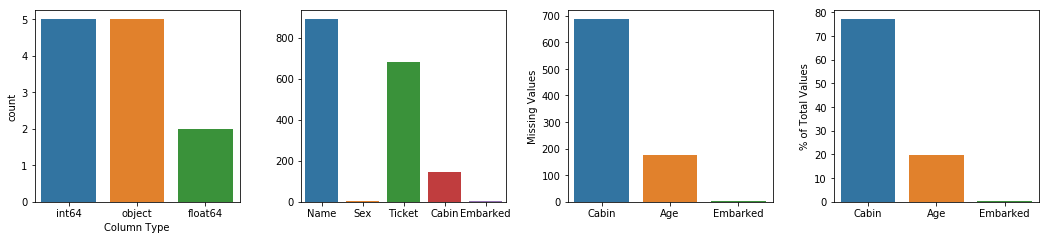

In [34]:
data_stats (train_df)

### Correct and Clean the data
* Remove any unnecessary columns
* Remove columns with majority of missing values
* Remove or clean outlier data

In [35]:
# CORRECT & CLEAN
# --------------------------

# Exclude features which will not impact the Target feature
remove_features = ['PassengerId','Cabin', 'Ticket']
remove_cols ([train_df], remove_features)

### EXPERIMENT with Transformers and Pipelines

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def all_but_first_column(X):
    return X[:, 1:]

# Convert a numeric continuous column to a binned column with discrete numeric values
# This will be wrapped with a FunctionTransformer so that it can be used within the
# pipeline
def num_to_bin(X, bins=None):
    # input X is a 2D numpy array and return value also must be a 2D array. 
    # pd.cut requires input which is reshaped to 1D. 
    # labels must be False to return a numpy array rather than a dataframe. 
    # Finally the result has to be reshaped again, back to a 2D array.
    return pd.cut(X.reshape(-1), bins=bins, labels=False).reshape(-1, 1)

# Define Custom Transformer as a trial to explore how they work. Currently
# it doesn't do anything useful, just changes the datatypes of all the 
# columns to be Categorical. Once we have identified some useful transformations
# will include that instead.
class TrialCustom (BaseEstimator, TransformerMixin):
    def __init__(self, dummy):
        self.dummy = dummy

    def fit(self, X, y=None):
        # Assumes X is a DataFrame
        return self

    def transform(self, X, y=None):
        # Assumes X is a DataFrame
        col_names = list(X)
        # loop to change each column to category type
        for col in col_names:
            X[col] = X[col].astype('category',copy=False)
        return X

# Define Custom Transformer to add a Title Feature. Right now all the logic is
# hardcoded to assume that a Name column is present and that the Title field
# will take on specific values which are mapped via a Dict. Also all the logic
# happens in the transform() and not the fit() method, which may not be correct
# This will also not work for other datasets than Titanic. So work is needed
# to fix these issues.
class CreateFeatureTitle (BaseEstimator, TransformerMixin):
    def __init__(self, nameCol=None):
        self.nameCol = nameCol

    def fit(self, X, y=None):
        # Assumes X is a DataFrame
        return self

    def transform(self, X, y=None):
        # Assumes X is a DataFrame
        
        # NoOp if nameCol not present
        nameCol = self.nameCol
        if (nameCol is None):
            return (X)

        # Extract titles from name
        X['Title']=0
        for i in X:
            X['Title']=X[nameCol].str.extract('([A-Za-z]+)\.', expand=False)  # Use REGEX to define a search pattern

        # Map of aggregated titles, so that less frequently used titles can be
        # merged with the common ones
        titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

        # Group titles
        X['Title'] = X['Title'].map(titles_dict)
        
        # Count how many people have each of the titles
        #print (X.groupby(['Title'])[nameCol].count())
        
        # Remove the Name column by returning all columns other than Name
        return X.loc[:, X.columns != nameCol]
    
# Define transformers for categorical columns
cat_cols = ['Sex', 'Embarked', 'Name']
cat_title_step = ('title', CreateFeatureTitle(nameCol='Name'))
cat_cat_step = ('cat', TrialCustom(dummy=5))
cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))
#cat_le_step = ('le', LabelEncoder()) # TODO !!!! For some reason this gives an error when included
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))

# Define pipeline of categorical transformers
cat_pipe = Pipeline([cat_title_step, cat_cat_step, cat_si_step, cat_ohe_step])

# Define transformers for numeric columns
num_cols = ['Age', 'Fare']
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())

# Define pipeline of numeric transformers
num_pipe = Pipeline([num_si_step, num_ss_step])

# Define transformers for numeric columns to be discretised
discrete_cols = ['Age']
discrete_si_step = ('si', SimpleImputer(strategy='median'))
discrete_bin_step = ('bin', KBinsDiscretizer(n_bins = 8, encode='ordinal'))

# Define pipeline of discretised transformers
discrete_pipe = Pipeline([discrete_si_step, discrete_bin_step])

# Define transformers for numeric-to-binning columns
num2bin_cols = ['Age']
num2bin_transform = FunctionTransformer(num_to_bin, 
                        kw_args={'bins': [0, 12, 50, 200]}, 
                        validate=True)
num2bin_si_step = ('si', SimpleImputer(strategy='median'))
num2bin_bin_step = ('bin', num2bin_transform)

# Define pipeline of num_to_bin transformers
num2bin_pipe = Pipeline([num2bin_si_step, num2bin_bin_step])

# Use ColumnTransformer to select which pipeline is applied to which columns
transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols),
                ('discrete', discrete_pipe, discrete_cols),
                ('num2bin', num2bin_pipe, num2bin_cols)]
ct = ColumnTransformer(transformers=transformers)

# Retrieve individual transformers within the pipeline if needed
'''
ohe = ct.named_transformers_['cat'].named_steps['ohe']
ohe.get_feature_names()
#exp_train

# Retrieve individual transformers within the pipeline if needed
bint = ct.named_transformers_['discrete'].named_steps['bin']
bint.bin_edges_
'''

"\nohe = ct.named_transformers_['cat'].named_steps['ohe']\nohe.get_feature_names()\n#exp_train\n\n# Retrieve individual transformers within the pipeline if needed\nbint = ct.named_transformers_['discrete'].named_steps['bin']\nbint.bin_edges_\n"

CV accuracy: 0.789 +/- 0.039


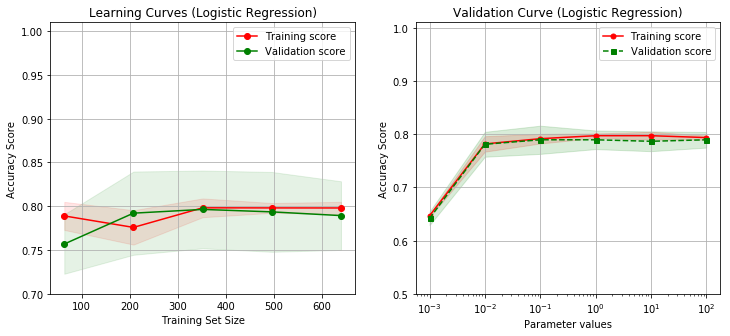

In [37]:
def plot_curves (model, X, y):
    # Figure and axes to plot learning and validation curves
    fig, axs = plt.subplots(1,2, figsize = (12, 5))
    
    # Plot learning curves
    title = "Learning Curves (Logistic Regression)"
    cv = 10
    plt.sca(axs[0]) # Set the current axes to first subplot
    plot_learning_curve(model, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=1);

    # Plot validation curve
    title = 'Validation Curve (Logistic Regression)'
    param_name = 'logreg__C'
    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
    cv = 10
    plt.sca(axs[1]) # Set the current axes to next subplot
    plot_validation_curve(estimator=model, title=title, X=X, y=y, param_name=param_name,
                          ylim=(0.5, 1.01), param_range=param_range);

# Split data into training and test set
df_X = train_df.drop('Survived', axis=1)
df_y = train_df ['Survived']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.2, random_state=1)

ml_pipe = Pipeline([('transform', ct), ('logreg', LogisticRegression())])
ml_pipe.fit(X_train, y_train)
scores = cross_val_score(ml_pipe, X_train, y_train, cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

plot_curves (ml_pipe, X_train, y_train)

### END EXPERIMENT

### Complete the data
* Fill any missing values

In [38]:
# COMPLETE
# --------------------------

# Impute all missing values
impute_missing_values (train_df, ['Age', 'Embarked'])

### Visualise the data
* Distribution of the data

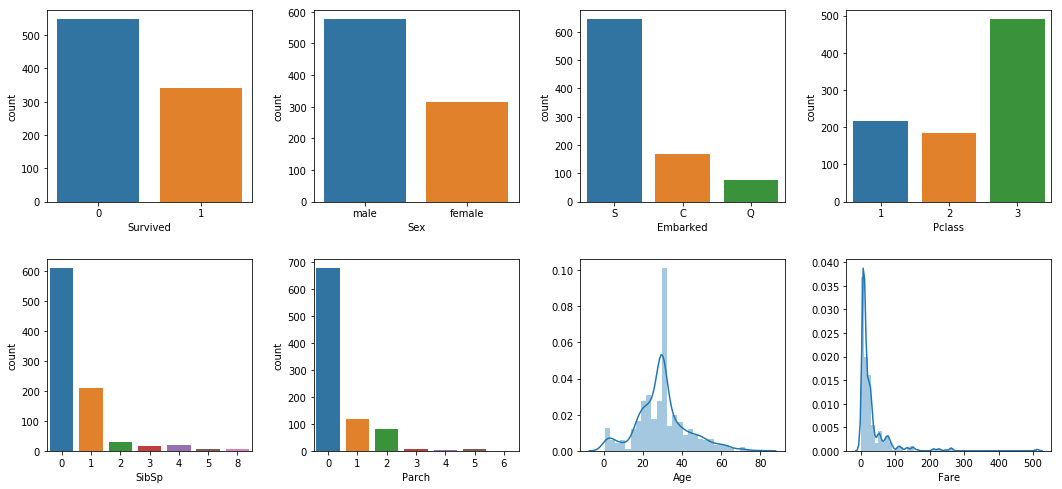

In [39]:
data_distrib (train_df, ['Survived', 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'], ['Age', 'Fare'])

### Convert the data
* Convert Numeric Continuous features to Categorical by Binning
* Encode Categorical Nominal (text) features with Label Encoding or One-Hot Encoding
* Scale/Normalise Numeric Continuous features

In [40]:
# CONVERT
# --------------------------
# Define categorical variables
train_df['Sex'] = pd.Categorical(train_df['Sex'])
train_df['Embarked'] = pd.Categorical(train_df['Embarked'])

# Convert numerical features to ordinal by binning
num_to_cat (train_df, 'Age', 'AgeBin', 8, range(1, 9))
num_to_cat (train_df, 'Age', 'AgeType', bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])

# Label encode categorical features
encode_cat (train_df, 'Sex', 'SexCode')
encode_cat (train_df, 'Embarked', 'EmbarkedCode')

# One-hot encode categorical features
# NB: This works only for categorical features with string values not numbers
# So doing this for the same features again simply as a test exercise
train_df = encode_cat_onehot (train_df, ['Sex', 'Embarked'])

In [41]:
train_df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBin,AgeType,SexCode,EmbarkedCode,Sex_male,Embarked_Q,Embarked_S
670,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",female,40.0,1,1,39.0000,S,4,Adult,0,2,0,0,1
812,0,2,"Slemen, Mr. Richard James",male,35.0,0,0,10.5000,S,4,Adult,1,2,1,0,1
618,1,2,"Becker, Miss. Marion Louise",female,4.0,2,1,39.0000,S,1,Child,0,2,0,0,1
325,1,1,"Young, Miss. Marie Grice",female,36.0,0,0,135.6333,C,4,Adult,0,0,0,0,0
510,1,3,"Daly, Mr. Eugene Patrick",male,29.0,0,0,7.7500,Q,3,Adult,1,1,1,1,0


### Run a Baseline Model
* Try variations with Label-Encoded and One-Hot Encoded versions
* Try variations with and without Normalised feature values

CV accuracy: 0.792 +/- 0.032


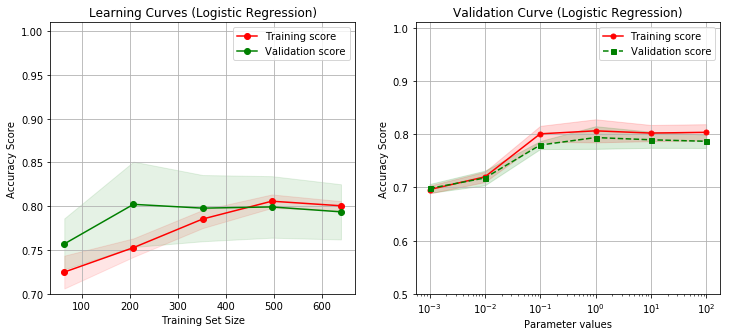

In [42]:
# First try with label encoded features
X = train_df [['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'SexCode', 'EmbarkedCode']]
y = train_df ['Survived']

validate_model (X, y)

CV accuracy: 0.799 +/- 0.033


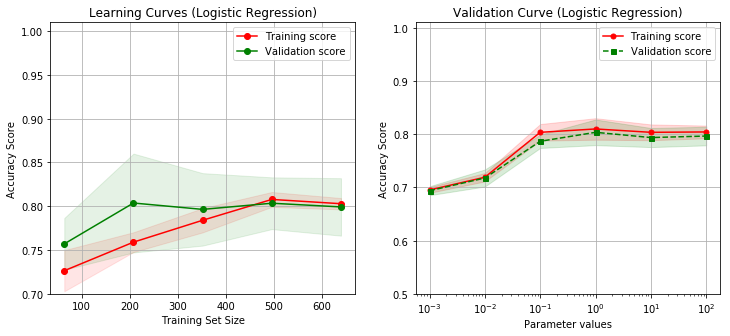

In [43]:
# Try with one-hot encoded features
X = train_df [['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']]
y = train_df ['Survived']

validate_model (X, y)

CV accuracy: 0.798 +/- 0.034


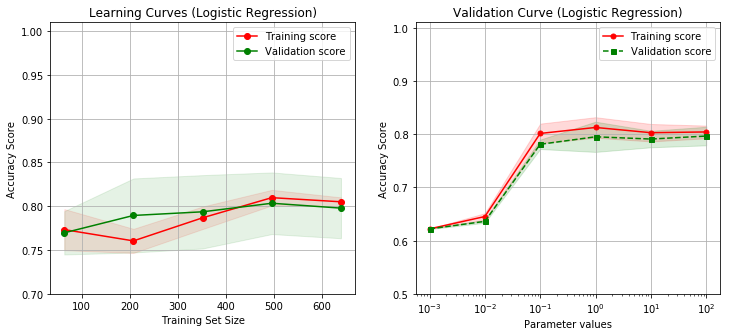

In [44]:
# CONVERT
# --------------------------
# Min-max scaling of numerical features
minmax_scaling (train_df, ['Age', 'Fare'])

# Try with one-hot encoded features
X = train_df [['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']]
y = train_df ['Survived']

validate_model (X, y)

### Create new features based on Domain Knowledge

CV accuracy: 0.799 +/- 0.043


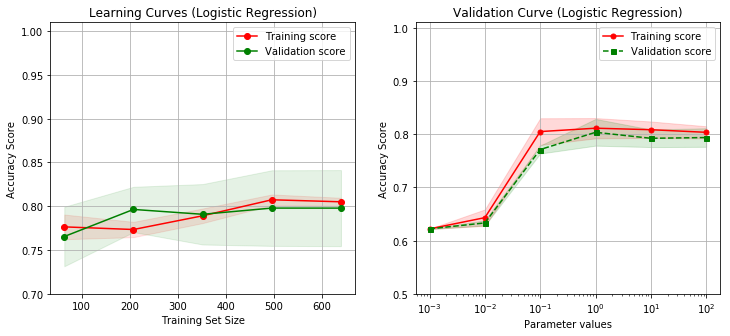

In [45]:
# CREATE
# --------------------------
# Create Family feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch']

X = train_df [['Pclass', 'Age', 'FamilySize', 'Fare', 'SexCode', 'EmbarkedCode']]
y = train_df ['Survived']

validate_model (X, y)

In [46]:
# CREATE
# --------------------------
# Create Title feature

# Extract titles from name
train_df['Title']=0
for i in train_df:
    train_df['Title']=train_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)  # Use REGEX to define a search pattern

# Count how many people have each of the titles
print (train_df.groupby(['Title'])['Name'].count())

# Map of aggregated titles, so that less frequently used titles can be
# merged with the common ones
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

# Group titles
train_df['Title'] = train_df['Title'].map(titles_dict)

# Transform into categorical
train_df['Title'] = pd.Categorical(train_df['Title'])

# Fill missing values and encode
train_df['Title'] = train_df['Title'].fillna('Other')
encode_cat (train_df, 'Title', 'TitleCode')

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: Name, dtype: int64


### Exploratory Data Analysis - Univariate

### Exploratory Data Analysis - Bivariate (with the Target feature)

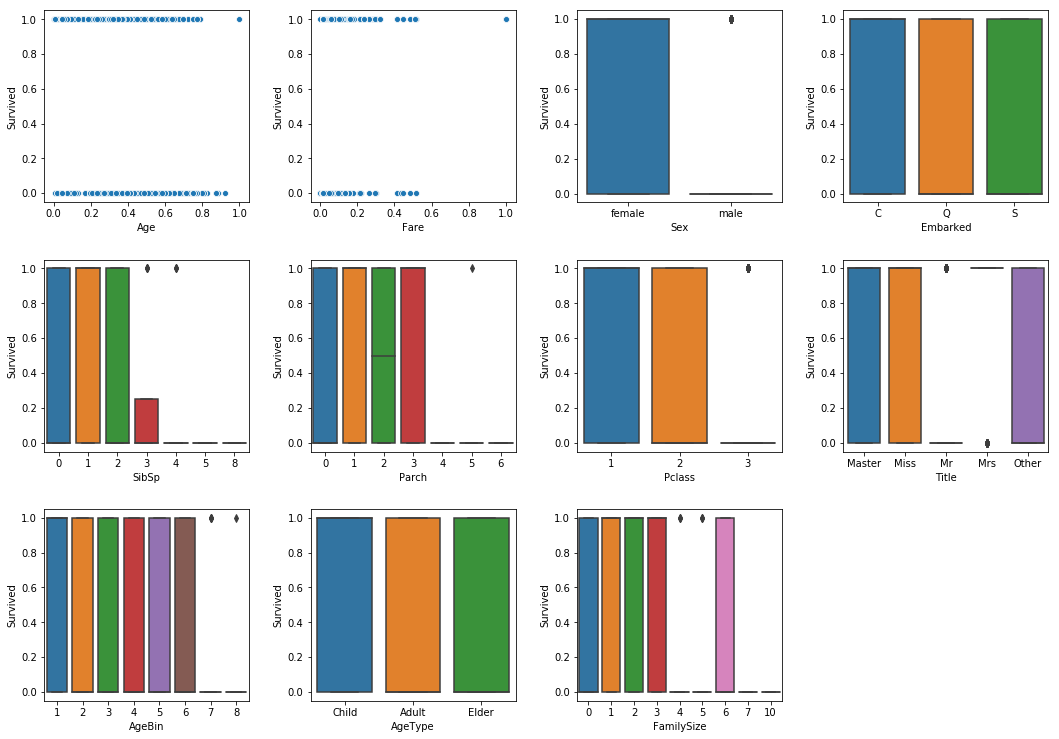

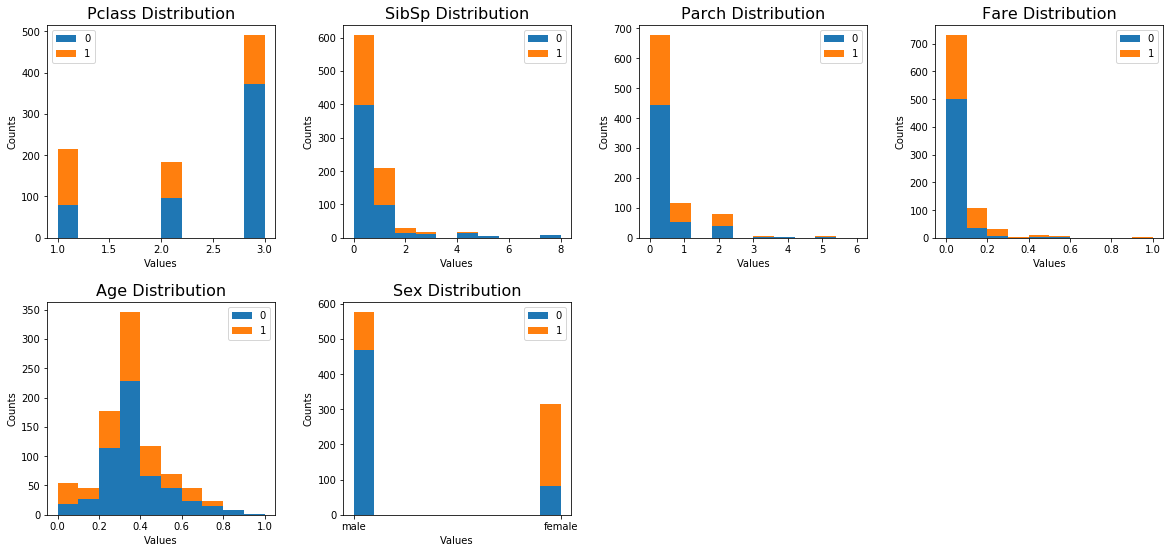

In [47]:
data_target (train_df, ['Sex', 'Embarked', 'SibSp', 'Parch', 'Pclass', 'Title', 'AgeBin', 'AgeType', 'FamilySize'], ['Age', 'Fare'], 'Survived')
plot_stackhist(train_df, ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Sex'], 'Survived')

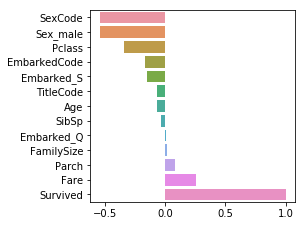

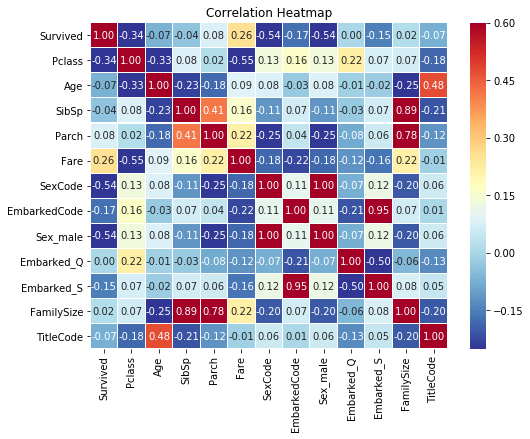

In [48]:
data_correlations (train_df, ['dummy'], 'Survived')

### Create new features based on Polynomials

CV accuracy: 0.837 +/- 0.038


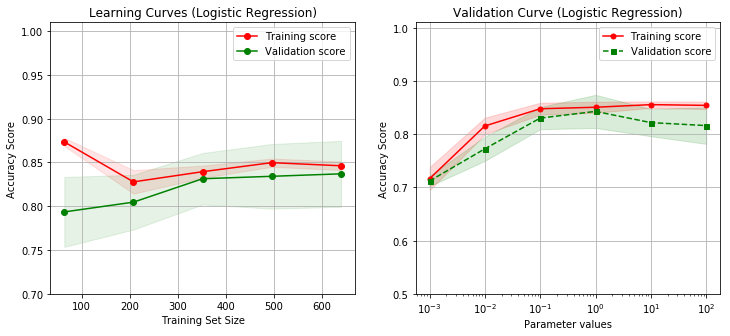

In [49]:
# CREATE (POLYNOMIAL)
# --------------------------

X = train_df [['Pclass', 'Age', 'FamilySize', 'Fare', 'SexCode', 'EmbarkedCode', 'TitleCode']]
X, _ = polynomial_features (X, None)
y = train_df ['Survived']

validate_model (X, y)

### Create Features by Aggregating Secondary (child) tables
* Aggregate Numeric features
* Aggregate Categorical features

In [ ]:
# AGGREGATE
# --------------------------

# Compute aggregate statistics for numeric columns ...
#agd = agg_numeric(train_df, group_var = 'country', stats = ['count', 'mean', 'max', 'min', 'sum'], df_name = 'ctry')
# ...and merge with the main data, and fill in empty values with 0s
#agm = md.merge(agd, on = 'country', how = 'left')
#fill_missing (agm)

# Note that we are aggregating stats for categorical columns which have now been one-hot encoded.
# Since these were not originally numeric values, the most meaningful stats are mean and sum
# Other stats like min and max do not make sense for such columns
# 
# The sum represents the count of that category value for that Country ID and 
# the mean represents the normalized count of that category value for that Country ID 
# ie. count of that value / total count of all values for that Country ID
# One-hot encoding makes the process of calculating these counts and normalised counts very easy
#odm = agg_numeric(od, group_var = 'country_id', stats = ['mean', 'sum'], df_name = 'ctry')

### Feature Selection
* Remove redundant features
* Select the best combination of features

In [50]:
base_score = 0.792
k_best_features = feature_select(X, y, base_score)

CV accuracy (number of features = 1): 0.787 +/- 0.028
CV accuracy (number of features = 2): 0.790 +/- 0.029
CV accuracy (number of features = 3): 0.809 +/- 0.023
CV accuracy (number of features = 4): 0.831 +/- 0.035
CV accuracy (number of features = 5): 0.824 +/- 0.030
CV accuracy (number of features = 6): 0.831 +/- 0.028
CV accuracy (number of features = 7): 0.829 +/- 0.029
CV accuracy (number of features = 8): 0.827 +/- 0.029
CV accuracy (number of features = 9): 0.826 +/- 0.028
CV accuracy (number of features = 10): 0.826 +/- 0.028
CV accuracy (number of features = 11): 0.826 +/- 0.029
CV accuracy (number of features = 12): 0.826 +/- 0.028
CV accuracy (number of features = 13): 0.824 +/- 0.028
CV accuracy (number of features = 14): 0.825 +/- 0.030
CV accuracy (number of features = 15): 0.826 +/- 0.031
CV accuracy (number of features = 16): 0.827 +/- 0.031
CV accuracy (number of features = 17): 0.834 +/- 0.034
CV accuracy (number of features = 18): 0.828 +/- 0.036
CV accuracy (number

CV accuracy: 0.839 +/- 0.032


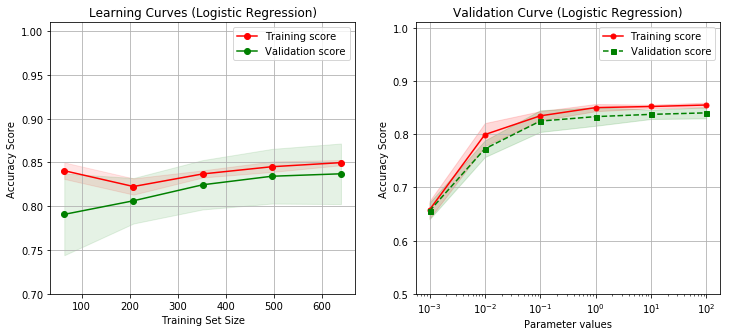

In [51]:
# Validate the model with the best selection of features
X_best = selected_df (X, y, k_best_features)
validate_model (X_best, y)

### Model Selection 
* Evaluate best hyperparameter values for each algorithm
* Select the best algorithm

In [52]:
X = train_df [['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'SexCode', 'EmbarkedCode']]
y = train_df ['Survived']

algo_df, param_df, metrics_df, confmat, multi_score_info = best_model (X, y)

Algo  Logistic Regression  has accuracy  79.72846441947566 with std 2.63060530341239
Algo  K Nearest Neighbours  has accuracy  81.13295880149813 with std 1.472584804414124
Algo  Decision Tree  has accuracy  82.02247191011237 with std 2.545733788894879
Algo  Support Vector Machine  has accuracy  80.94569288389512 with std 1.9061285060292361
Algo  Random Forest  has accuracy  80.0561797752809 with std 3.7309386467552152
Best accuracy is  82.02247191011237
Best params  {'criterion': 'gini', 'max_depth': 3}


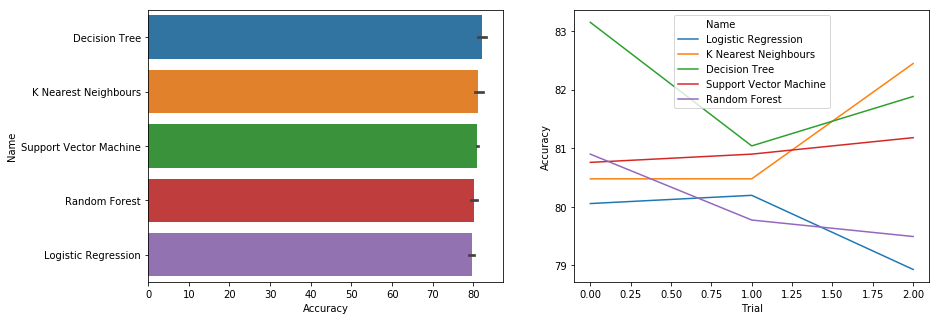

In [53]:
fig, axis = plt.subplots(1,2,figsize=(14,5))

sns.barplot (y = 'Name', x = 'Accuracy', data = algo_df.sort_values('Accuracy', ascending=False), ax=axis[0])
sns.lineplot (x = 'Trial', y = 'Accuracy', hue = 'Name', data = algo_df, ax=axis[1])

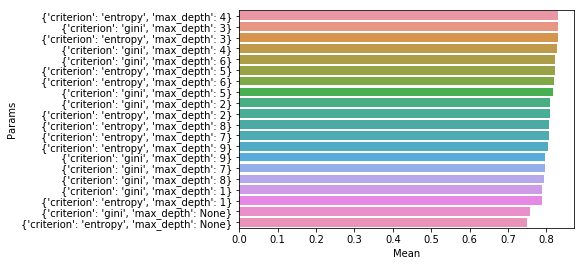

In [54]:
sns.barplot (x = 'Mean', y = 'Params', data = param_df.sort_values('Mean', ascending=False))

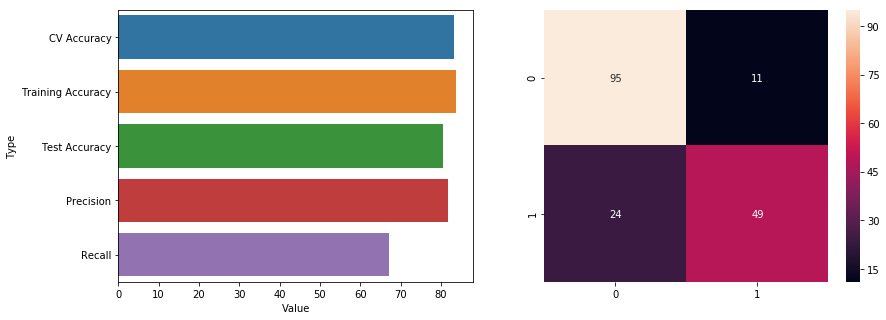

In [55]:
fig, axis = plt.subplots(1,2,figsize=(14,5))

sns.barplot (y = 'Type', x = 'Value', data = metrics_df, ax=axis[0])
sns.heatmap(confmat,annot=True,fmt='2.0f', ax=axis[1])

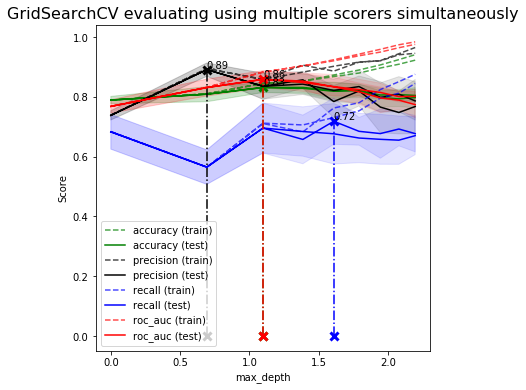

In [56]:
plot_multi_score (multi_score_info)

### Ensemble Models 
* Voting
* Bagging
* Boosting

In [57]:
X = train_df [['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'SexCode', 'EmbarkedCode']]
y = train_df ['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [58]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(X_train,y_train)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(X_test,y_test))
cross=cross_val_score(ensemble_lin_rbf,X,y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.7877094972067039
The cross validated score is 0.8114686187719895


In [59]:
# Ensemble - Bagged KNN

from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print('The accuracy for bagged KNN is:',accuracy_score(prediction,y_test))
result=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.7821229050279329
The cross validated score for bagged KNN is: 0.8003197707411192


In [60]:
# Ensemble - Bagged Decision Tree - OPTIMISED HYPER PARAMETERS

model=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 4, criterion = 'entropy'),random_state=0,n_estimators=100)
model.fit(X_train,y_train)
prediction=model.predict(X_test)
print('The accuracy for bagged Decision Tree is:', accuracy_score(prediction,y_test))
result=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.7877094972067039
The cross validated score for bagged Decision Tree is: 0.820508455339916


In [61]:
# Ensemble - Ada Boosting

from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8070494268527977


In [62]:
# Ensemble - Stochastic Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8283608557484963


In [63]:
# Ensemble - XG Boost

import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.8226923731699012


In [ ]:
# Ensemble - Ada Boosting with Hyperparameter Tuning

n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

### Exploratory Data Analysis - Multivariate 
* for specific features as needed

The following plots are practice examples of possible visualisations with Seaborn which may be useful. But at the moment I'm not able to figure out what concrete uses I can put them to, nor can I come up with patterns that can be applied generically.

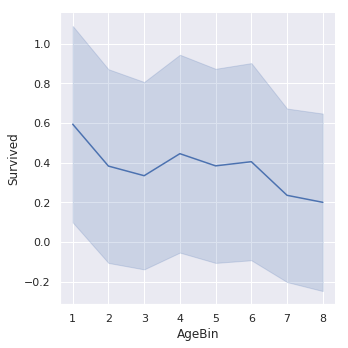

In [66]:
sns.set(style="darkgrid")

# Line plot with standard deviation
sns.relplot(x="AgeBin", y="Survived", kind="line", ci="sd", data=train_df);

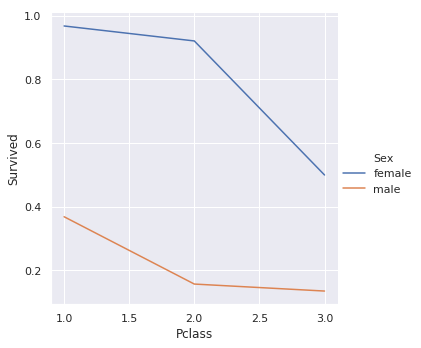

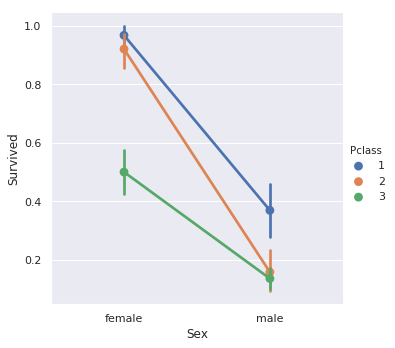

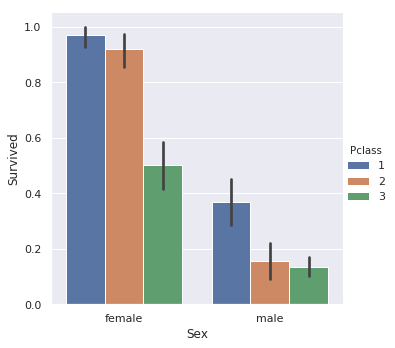

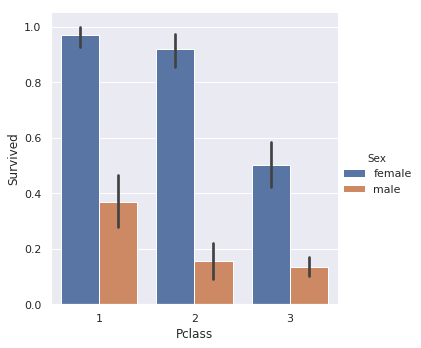

In [67]:
# 2 variables (Sex and Pclass) with target (Survived)
sns.relplot(x="Pclass", y="Survived", hue = "Sex", kind="line", ci=None, data=train_df);
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="point", data=train_df);
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=train_df)
sns.catplot(x="Pclass", y="Survived", hue="Sex", kind="bar", data=train_df)

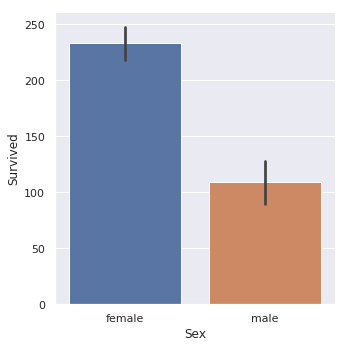

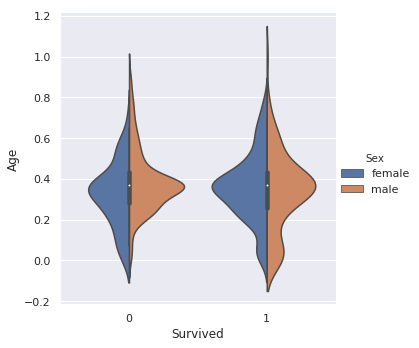

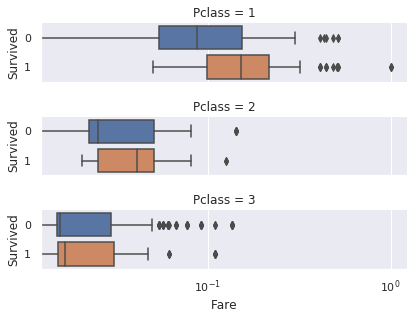

In [68]:
# Plot totals not just mean
sns.catplot(x="Sex", y="Survived", kind="bar", estimator=sum, data=train_df)

# One numeric and one categorical (Sex and Age) with Target
sns.catplot(x="Survived", y="Age", hue="Sex", kind="violin", split="True", data=train_df);

# One numeric and one categorical (Fare and Pclass) with Target
g = sns.catplot(x="Fare", y="Survived", row="Pclass",
                kind="box", orient="h", height=1.5, aspect=4,
                data=train_df)
g.set(xscale="log");

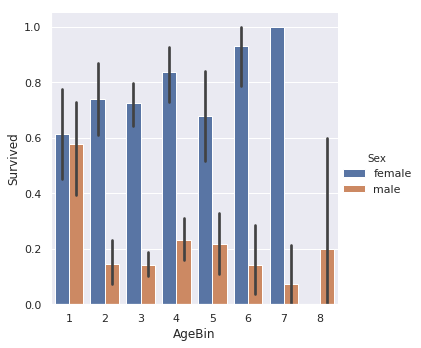

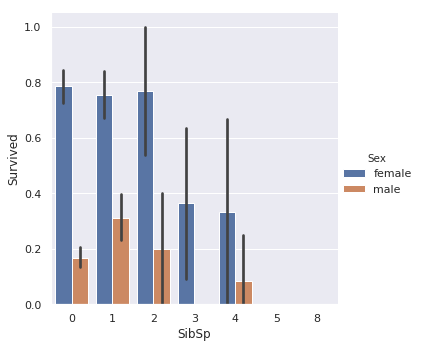

In [69]:
sns.catplot(x="AgeBin", y="Survived", hue="Sex", kind="bar", data=train_df)

sns.catplot(x="SibSp", y="Survived", hue="Sex", kind="bar", data=train_df)

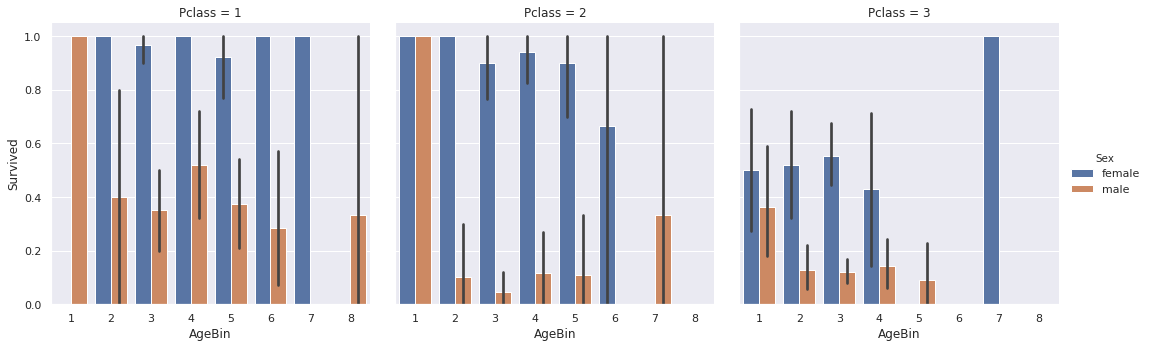

In [70]:
# Plot 4 variables using column facets
sns.catplot(x="AgeBin", y="Survived", hue="Sex", col = "Pclass", kind="bar", data=train_df)

In [71]:
# Plot KDE histograms with one variable and Target
fig, axis = plt.subplots(1,2,figsize=(14,6))

# Age vs Target on the left
sns.kdeplot (train_df[train_df['Survived'] == 0]['Age'], label="Died", ax=axis[0])
sns.kdeplot (train_df[train_df['Survived'] == 1]['Age'], label="Lived", ax=axis[0])

# Fare vs Target on the right
sns.kdeplot (train_df[train_df['Survived'] == 0]['Fare'], label="Died", ax=axis[1])
sns.kdeplot (train_df[train_df['Survived'] == 1]['Fare'], label="Lived", ax=axis[1])

SyntaxError: EOL while scanning string literal (<ipython-input-71-82eddc4252ed>, line 1)

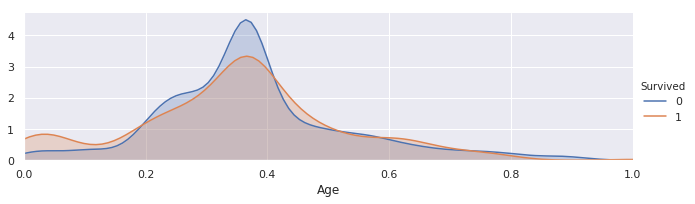

In [72]:
# Use FacetGrid instead of calling KDEplot directly
a = sns.FacetGrid( train_df, hue = 'Survived', aspect=3 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_df['Age'].max()))
a.add_legend()

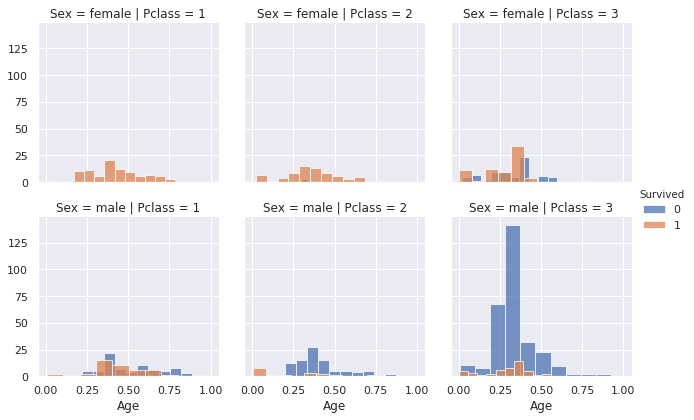

In [73]:
# Use FacetGrid to plot 2 variables (Sex and Pclass) vs Target
h = sns.FacetGrid(train_df, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

Text(0.5, 1.0, 'Pclass vs Age Survival Comparison')

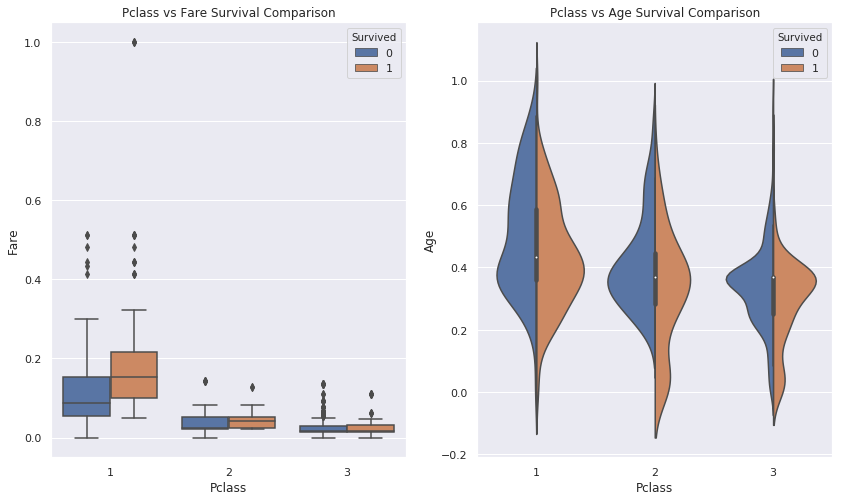

In [74]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,8))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = train_df, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = train_df, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

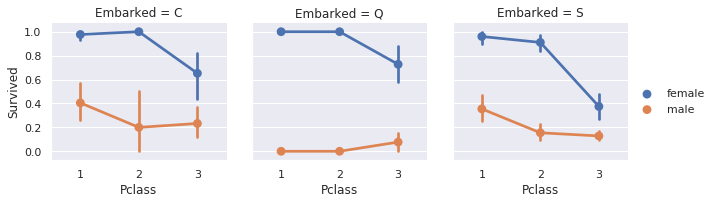

In [75]:
e = sns.FacetGrid(train_df, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95.0, palette = 'deep')
e.add_legend()

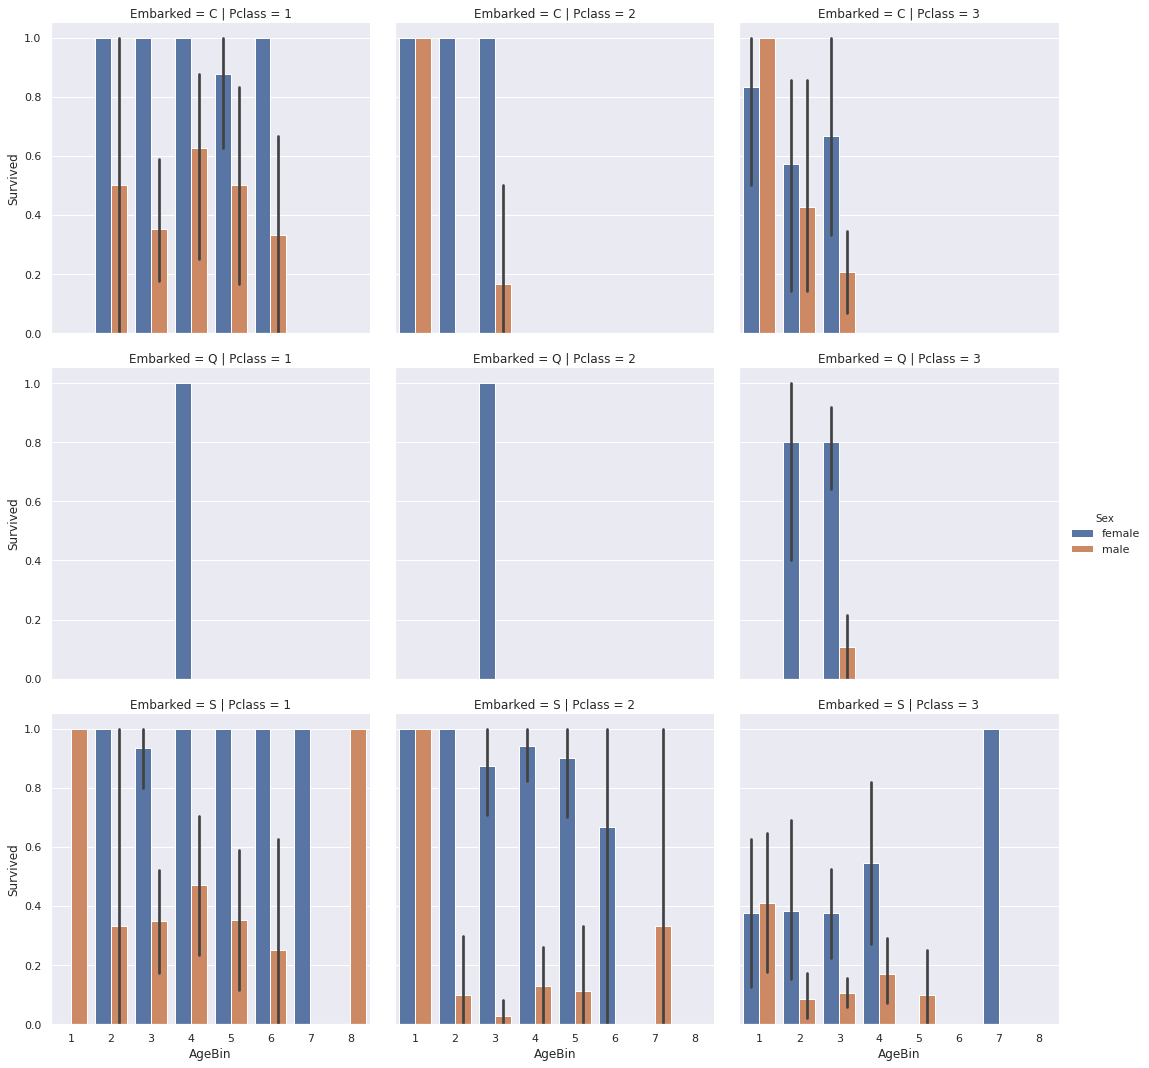

In [76]:
sns.catplot (x="AgeBin", y="Survived", hue="Sex", row="Embarked", col = "Pclass", kind="bar", data=train_df)

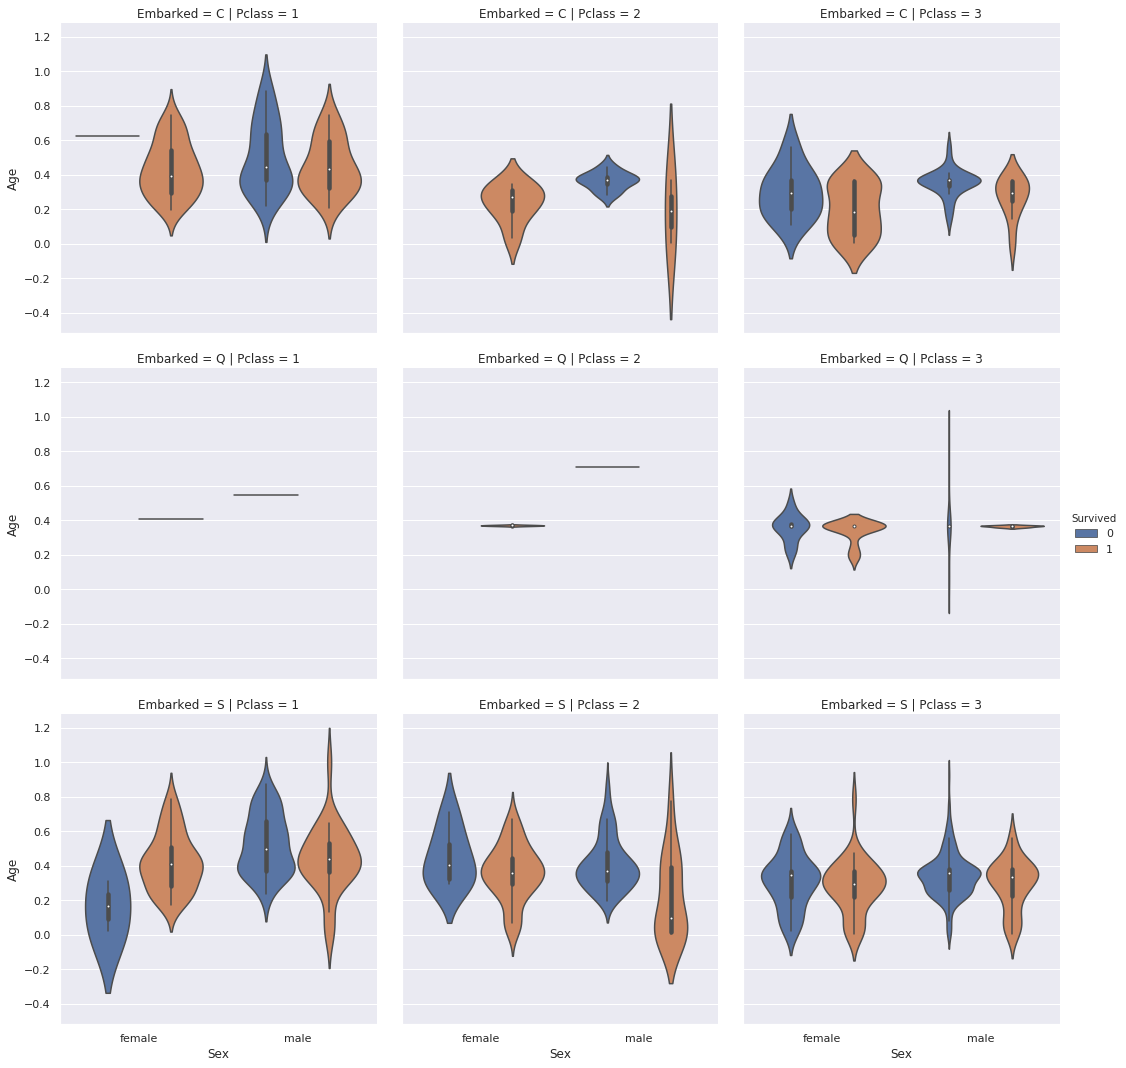

In [77]:
sns.catplot (x="Sex", y="Age", hue="Survived", row="Embarked", col = "Pclass", kind="violin", data=train_df)

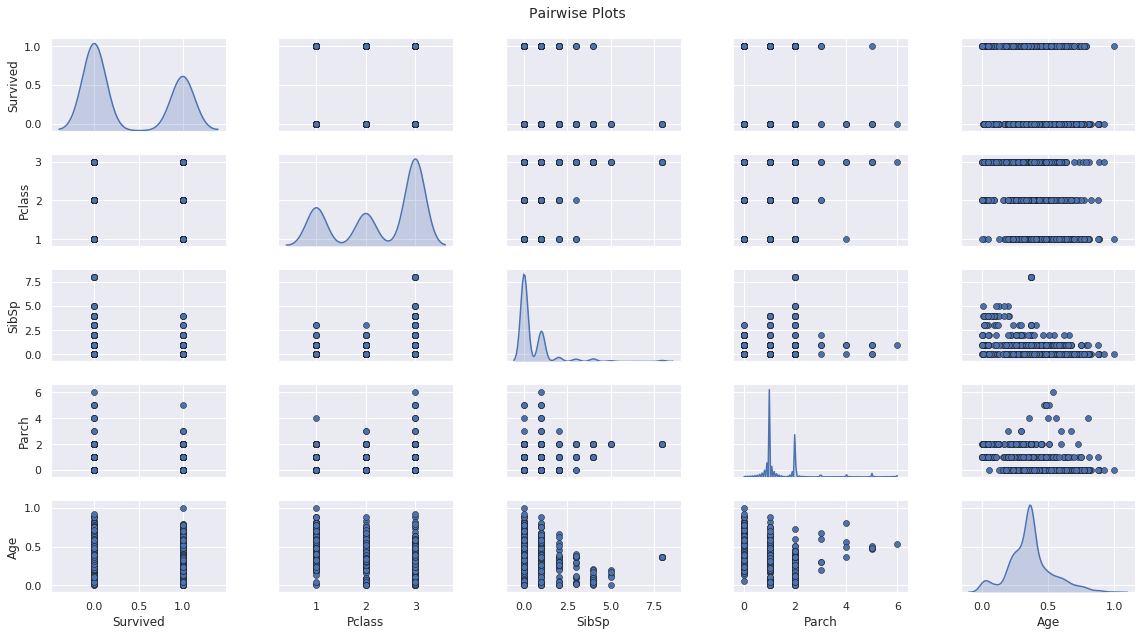

In [78]:
plot_pair(train_df, ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age'])

## Other Functions

This [notebook](http://https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2) had a few more functions. Include them if they are going to be generically useful.
* Function to Convert Data Types (def convert_types(df, print_info = False)) - this will help reduce memory usage by using more efficient types for the variables. For example category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).
* Function to Drop Missing Columns (def remove_missing_columns(train, test, threshold = 90))
* Function to Aggregate Stats Per Client (def aggregate_client(df, group_vars, df_names)) - for parent-child data tables. In this case the child tables contained data per-loan for each user, while the parent contained data per-user. So data rolled up at the per-loan level had to be then be rolled up again at the user level and merged with the parent data.
* Function to run a ML model (def model(features, test_features, encoding = 'ohe', n_folds = 5)) - Train and test a light gradient boosting model using cross validation, and also calculating feature importances
* Function to plot Feature Importances (def plot_feature_importances(df))